In [2]:
from ccs_fit.scripts.ccs_fetch import ccs_fetch

ccs_fetch(mode="CCS",DFT_DB="DFT.db",include_forces=True)

    Fetching data: 100%|██████████| 699/699 [00:09<00:00, 73.16it/s]


In [5]:
### Generate input.json file
import json

input={
    "General": {
        "interface": "CCS",
        "merging"  : "True",
        "do_ridge_regression":"False"
    },
    "Twobody": {
                "Xx-Xx": {
                        "Rcut": 5.5,
                        "Resolution": 0.25,
                        "Swtype": "sw",
                        "const_type" : "Mono"   
                }
        }
}
#SAVE TO FILE
with open('CCS_input.json', 'w') as f:
    json.dump(input, f, indent=8)

In [6]:
#RUN FIT
from ccs_fit import ccs_fit

ccs_fit("CCS_input.json")

    Generating one-body information from training-set.
        Added elements:  ['Cl', 'Na']
    Generating two-body potentials from one-body information.
    Adding pair: Cl-Cl
    Adding pair: Cl-Na
    Adding pair: Na-Na
    Applying monotonous constraints for pair:  Cl-Cl
    Applying monotonous constraints for pair:  Cl-Na
    Applying monotonous constraints for pair:  Na-Na
    There is linear dependence in stochiometry matrix!
    Removing onebody term: Na


    Finding optimum switch: 100%|██████████| 3360/3360 [00:25<00:00, 130.88it/s]


    The best switch is (13, 6, 14) with mse: 1.4174, corresponding to distances of [5.72 3.44 5.73] Å for element pairs ['Cl-Cl', 'Cl-Na', 'Na-Na'].


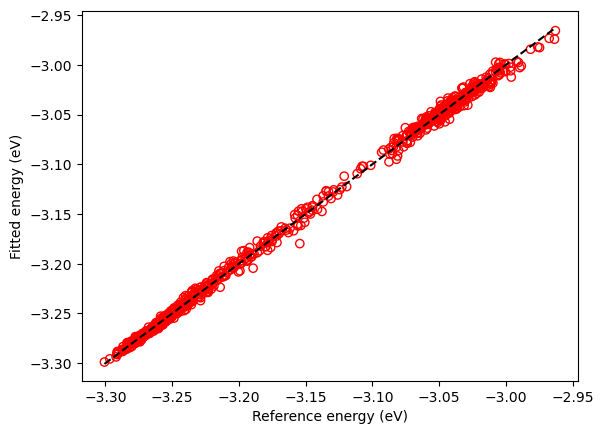

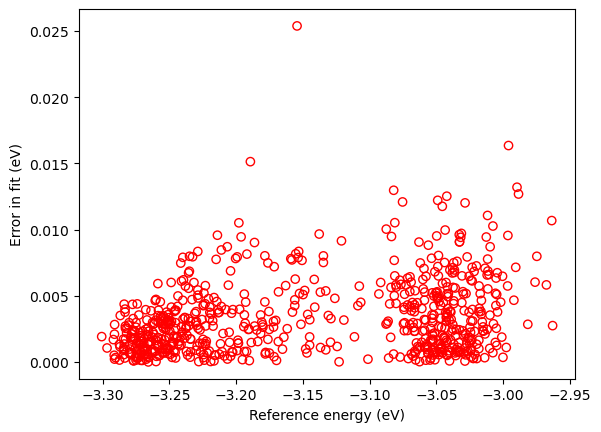

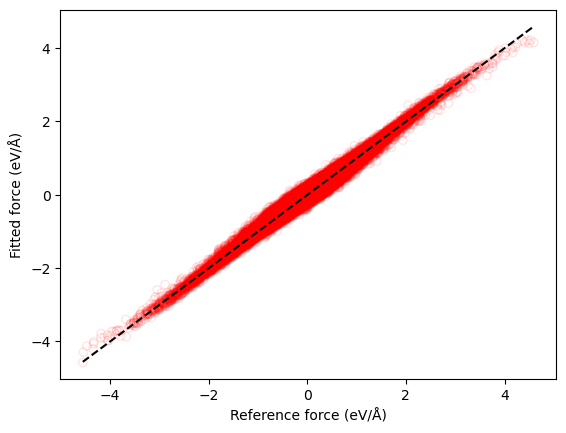

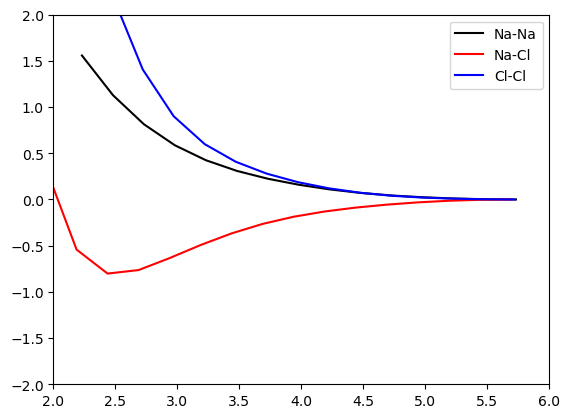

In [2]:

import numpy as np
import json
import matplotlib.pyplot as plt

with open("CCS_params.json", "r") as f:
    CCS_params = json.load(f)

with open("structures.json", "r") as f:
    training_set = json.load(f)


err=np.loadtxt("CCS_error.out")

err[:,0]=err[:,0]/err[:,3]
err[:,1]=err[:,1]/err[:,3]
err[:,2]=err[:,2]/err[:,3]

plt.xlabel('Reference energy (eV)')
plt.ylabel('Fitted energy (eV)')
plt.plot( [min(err[:,0]),max(err[:,0])],[min(err[:,0]),max(err[:,0])],'--',color='black'  )
plt.scatter(err[:,0],err[:,1],facecolors='none', edgecolors='red')
plt.show()
plt.xlabel('Reference energy (eV)')
plt.ylabel('Error in fit (eV)')
plt.scatter(err[:,0],err[:,2],facecolors='none', edgecolors='red')
plt.show()


err_F=np.loadtxt("CCS_error_forces.out")
plt.xlabel('Reference force (eV/Å)')
plt.ylabel('Fitted force (eV/Å)')
plt.plot( [min(err_F[:,0]),max(err_F[:,0])],[min(err_F[:,0]),max(err_F[:,0])],'--',color='black')
plt.scatter(err_F[:,0],err_F[:,1],facecolors='none', edgecolors='red',alpha=0.1 )
plt.show()

plt.xlim(2,6)
plt.ylim(-2.0,2.0)
# plt.xlabel('Distance (Å)')
# plt.ylabel('Potential (eV)')
r=np.array(CCS_params["Two_body"]["Na-Na"]["r"])
NaNa=np.array(CCS_params["Two_body"]["Na-Na"]["spl_a"])
plt.plot(r,NaNa,color='black',label="Na-Na")
r=np.array(CCS_params["Two_body"]["Cl-Na"]["r"])
NaCl=np.array(CCS_params["Two_body"]["Cl-Na"]["spl_a"])
plt.plot(r,NaCl,color='red',label="Na-Cl")
r=np.array(CCS_params["Two_body"]["Cl-Cl"]["r"])
ClCl=np.array(CCS_params["Two_body"]["Cl-Cl"]["spl_a"])
plt.plot(r,ClCl,color='blue',label="Cl-Cl")

plt.legend()
plt.show()

In [1]:
from ase.lattice.cubic import FaceCenteredCubic
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.langevin import Langevin
from ase import units
from ccs_fit.ase_calculator.ccs_ase_calculator import CCS
from ase.io.trajectory import Trajectory
from ase.build import bulk
import json


json_file = open("CCS_params.json")
CCS_params = json.load(json_file)



atoms=bulk('NaCl','rocksalt',a=6.369976562933614,cubic=True)
atoms=atoms*[2,2,2]
charge_dict={"Na":1,"Cl":-1}

calc = CCS(CCS_params=CCS_params)
atoms.calc=calc

print("Initial energy:", atoms.get_potential_energy())

T=1174 # IN KELVIN

# Set the momenta corresponding to T
MaxwellBoltzmannDistribution(atoms, temperature_K=T)

# We want to run MD with constant energy using the VelocityVerlet algorithm.
dyn = Langevin(atoms, 2 * units.fs, T * units.kB, 0.1)


def printenergy(a):
    """Function to print the potential, kinetic and total energy"""
    epot = a.get_potential_energy() / len(a)
    ekin = a.get_kinetic_energy() / len(a)
    print('Energy per atom: Epot = %.3feV  Ekin = %.3feV (T=%3.0fK)  '
          'Etot = %.3feV' % (epot, ekin, ekin / (1.5 * units.kB), epot + ekin))

#Equillibrate
printenergy(atoms)
for i in range(10):
    dyn.run(100)
    printenergy(atoms)

traj = Trajectory('moldyn.traj', 'w', atoms)
dyn.attach(traj.write, interval=100)


# Now run the dynamics
printenergy(atoms)
for i in range(200):
    print("STEP: ", i*100," ",end='')
    dyn.run(100)
    printenergy(atoms)

print("Final energy:", atoms.get_potential_energy())


c:\Users\jolku587\Anaconda3\envs\CCS_coding\lib\site-packages\ase\utils\__init__.py:62: FutureWarning: Please use atoms.cell.rank instead
  warnings.warn(warning)
c:\Users\jolku587\Anaconda3\envs\CCS_coding\lib\site-packages\ase\md\md.py:48: FutureWarning: Specify the temperature in K using the 'temperature_K' argument
  warnings.warn(FutureWarning(w))


Initial energy: -207.53612064567017
Energy per atom: Epot = -3.243eV  Ekin = 0.142eV (T=1101K)  Etot = -3.100eV
Energy per atom: Epot = -3.156eV  Ekin = 0.137eV (T=1060K)  Etot = -3.019eV
Energy per atom: Epot = -3.115eV  Ekin = 0.150eV (T=1161K)  Etot = -2.965eV
Energy per atom: Epot = -3.144eV  Ekin = 0.140eV (T=1086K)  Etot = -3.004eV
Energy per atom: Epot = -3.119eV  Ekin = 0.150eV (T=1160K)  Etot = -2.969eV
Energy per atom: Epot = -3.128eV  Ekin = 0.124eV (T=961K)  Etot = -3.004eV
Energy per atom: Epot = -3.130eV  Ekin = 0.158eV (T=1219K)  Etot = -2.973eV
Energy per atom: Epot = -3.120eV  Ekin = 0.163eV (T=1265K)  Etot = -2.957eV
Energy per atom: Epot = -3.104eV  Ekin = 0.140eV (T=1082K)  Etot = -2.964eV
Energy per atom: Epot = -3.122eV  Ekin = 0.127eV (T=979K)  Etot = -2.995eV
Energy per atom: Epot = -3.146eV  Ekin = 0.124eV (T=960K)  Etot = -3.022eV
Energy per atom: Epot = -3.146eV  Ekin = 0.124eV (T=960K)  Etot = -3.022eV
Energy per atom: Epot = -3.109eV  Ekin = 0.135eV (T=1045

In [19]:
# run some more

for i in range(200):
    print("STEP: ", i*100," ",end='')
    dyn.run(100)
    printenergy(atoms)

STEP:  0  Energy per atom: Epot = -3.084eV  Ekin = 0.148eV (T=1141K)  Etot = -2.937eV
STEP:  100  Energy per atom: Epot = -3.091eV  Ekin = 0.146eV (T=1128K)  Etot = -2.946eV
STEP:  200  Energy per atom: Epot = -3.084eV  Ekin = 0.151eV (T=1167K)  Etot = -2.933eV
STEP:  300  Energy per atom: Epot = -3.100eV  Ekin = 0.130eV (T=1008K)  Etot = -2.970eV
STEP:  400  Energy per atom: Epot = -3.103eV  Ekin = 0.117eV (T=905K)  Etot = -2.986eV
STEP:  500  Energy per atom: Epot = -3.083eV  Ekin = 0.152eV (T=1177K)  Etot = -2.931eV
STEP:  600  Energy per atom: Epot = -3.108eV  Ekin = 0.143eV (T=1107K)  Etot = -2.965eV
STEP:  700  Energy per atom: Epot = -3.088eV  Ekin = 0.142eV (T=1096K)  Etot = -2.946eV
STEP:  800  Energy per atom: Epot = -3.067eV  Ekin = 0.139eV (T=1072K)  Etot = -2.929eV
STEP:  900  Energy per atom: Epot = -3.105eV  Ekin = 0.158eV (T=1219K)  Etot = -2.948eV
STEP:  1000  Energy per atom: Epot = -3.109eV  Ekin = 0.144eV (T=1112K)  Etot = -2.966eV
STEP:  1100  Energy per atom: Epot

Na Diffusion constant: 5.398235637456964e-05  cm^2/s, Standard deviation 1.8705819538394858e-05
Cl Diffusion constant: 3.801772038635099e-05  cm^2/s, Standard deviation 1.4333003533872796e-05
REFERENCE VALUES FROM GAP POTENTIALS https://pubs.acs.org/doi/full/10.1021/acs.jpcc.0c08870
Na Diffusion constant:  9.78E-5 cm^2/s, Standard deviation: 0.19E-5 
Cl Diffusion constant:  7.73E-5 cm^2/s, Standard deviation: 0.11E-5 


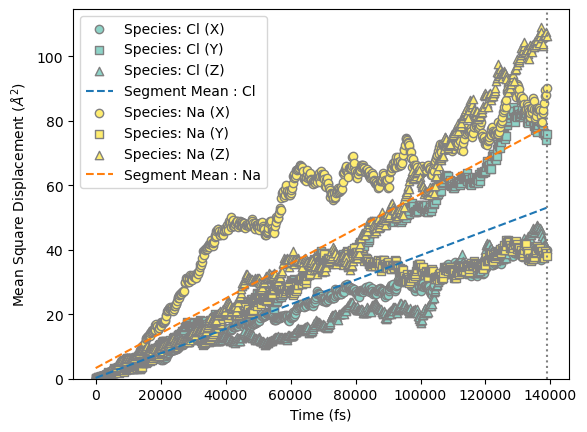

In [17]:
from ase.md.analysis import DiffusionCoefficient
from ase.io.trajectory import Trajectory
traj = Trajectory('moldyn.traj')
Df=DiffusionCoefficient(traj, 200*units.fs, atom_indices=None, molecule=False)
Df.calculate()
D=Df.get_diffusion_coefficients()
conv_factor=units.fs*0.1

print("Na Diffusion constant:", D[0][1]*conv_factor," cm^2/s, Standard deviation",D[1][1]*conv_factor)
print("Cl Diffusion constant:", D[0][0]*conv_factor," cm^2/s, Standard deviation",D[1][0]*conv_factor)


print("REFERENCE VALUES FROM GAP POTENTIALS https://pubs.acs.org/doi/full/10.1021/acs.jpcc.0c08870")

print("Na Diffusion constant:  9.78E-5 cm^2/s, Standard deviation: 0.19E-5 ")
print("Cl Diffusion constant:  7.73E-5 cm^2/s, Standard deviation: 0.11E-5 ")
Df.plot()

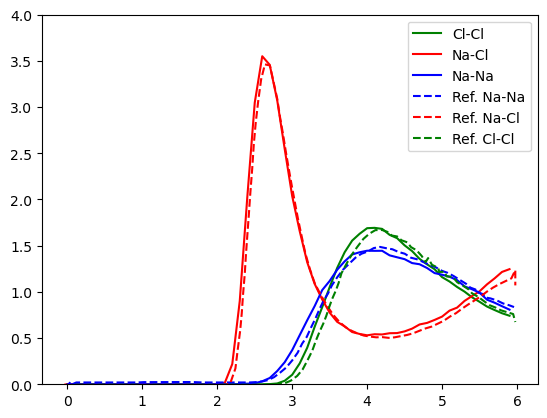

In [20]:
#Radial distribution function

import numpy as np
import itertools as iter
traj = Trajectory('moldyn.traj')

N_bins=60

h_NaNa=np.zeros((N_bins,))
h_NaCl=np.zeros((N_bins,))
h_ClCl=np.zeros((N_bins,))
counter=0
N=len(atoms)

d_NaNa=[]
d_NaCl=[]
d_ClCl=[]

mask_Na=atoms.symbols=='Na'
mask_Cl=atoms.symbols=='Cl'

for a in traj:
    counter += 1
    a.wrap()
    d_all = np.array(a.get_all_distances(mic=True)) # NxN matrix with all pair-distances
    d_NaNa.extend( d_all[mask_Na,:] [:,mask_Na].flatten()) #Extract Na-Na distances
    d_NaCl.extend( d_all[mask_Na,:] [:,mask_Cl].flatten()) #Extract Na-Cl distances
    d_ClCl.extend( d_all[mask_Cl,:] [:,mask_Cl].flatten()) #Extract Cl-Cl distances
           

hh,r=np.histogram(d_NaNa,range=(0,6),bins=60)
vol=(4/3.)*np.pi*r**3
nrm=np.diff(vol)
h_NaNa = 4*hh/nrm/N/counter
h_NaNa[0]=0

hh,r=np.histogram(d_NaCl,range=(0,6),bins=60)
vol=(4/3.)*np.pi*r**3
nrm=np.diff(vol)
h_NaCl = 4*hh/nrm/N/counter
h_NaCl[0]=0

hh,r=np.histogram(d_ClCl,range=(0,6),bins=60)
vol=(4/3.)*np.pi*r**3
nrm=np.diff(vol)
h_ClCl = 4*hh/nrm/N/counter
h_ClCl[0]=0


import matplotlib.pyplot as plt
Dens=len(atoms)/atoms.get_volume()

plt.ylim(0,4)
plt.plot(r[0:-1],h_ClCl/Dens,label="Cl-Cl",color="green")
plt.plot(r[0:-1],h_NaCl/Dens,label="Na-Cl",color="red")
plt.plot(r[0:-1],h_NaNa/Dens,label="Na-Na",color="blue")


ref_NaNa=np.loadtxt('./RefData/NaNa.txt')
ref_NaCl=np.loadtxt('./RefData/NaCl.txt')
ref_ClCl=np.loadtxt('./RefData/ClCl.txt')

plt.plot(ref_NaNa[:,0],ref_NaNa[:,1,],'--',label="Ref. Na-Na",color="blue")
plt.plot(ref_NaCl[:,0],ref_NaCl[:,1,],'--',label="Ref. Na-Cl",color="red")
plt.plot(ref_ClCl[:,0],ref_ClCl[:,1,],'--',label="Ref. Cl-Cl",color="green")


plt.legend()

In [6]:
!ase-gui moldyn.traj

Please use "ase gui" instead of "ase-gui"


In [21]:
!ase-gui

Please use "ase gui" instead of "ase-gui"
Rendering with povray:
 | Building bonds
 | Writing files for image H72Al4N12O72.pov ...


Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\jolku587\Anaconda3\envs\CCS_coding\lib\tkinter\__init__.py", line 1921, in __call__
    return self.func(*args)
  File "C:\Users\jolku587\Anaconda3\envs\CCS_coding\lib\site-packages\ase\gui\render.py", line 133, in ok
    renderer.render(povray_executable=self.povray_executable.value, clean_up=False)
  File "C:\Users\jolku587\Anaconda3\envs\CCS_coding\lib\site-packages\ase\io\pov.py", line 568, in render
    check_call(cmd, stderr=stderr)
  File "C:\Users\jolku587\Anaconda3\envs\CCS_coding\lib\subprocess.py", line 364, in check_call
    retcode = call(*popenargs, **kwargs)
  File "C:\Users\jolku587\Anaconda3\envs\CCS_coding\lib\subprocess.py", line 345, in call
    with Popen(*popenargs, **kwargs) as p:
  File "C:\Users\jolku587\Anaconda3\envs\CCS_coding\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\jolku587\Anaconda3\envs\CCS_c